## 1. Importing Libraries

In [132]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
pd.options.display.float_format = '{:.5f}'.format

from catboost import CatBoostRegressor

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the data

In [2]:
# Load the data
train = pd.read_csv("../data/Housing_dataset_train.csv")
test = pd.read_csv("../data/Housing_dataset_test.csv")
submission = pd.read_csv("../data/Sample_submission.csv")

In [3]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500
1,2748,Ondo,Apartment,NaN,2.00000,4.00000,1672416.68900
2,9261,Ekiti,NaN,7.00000,5.00000,NaN,3364799.81400
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600
4,10300,Kogi,Terrace duplex,NaN,5.00000,6.00000,2600700.89800


In [4]:
test.head(2)

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4


In [5]:
print(f"The train dataset contains {train.shape[0]} rows and {train.shape[1]} columns")

The train dataset contains 14000 rows and 7 columns


In [6]:
print(f"The test dataset contains {test.shape[0]} rows and {test.shape[1]} columns")

The test dataset contains 6000 rows and 6 columns


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [8]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.00000,12201.00000,12195.00000,12189.00000,14000.00000
mean,4862.70036,4.30817,3.13424,3.16983,2138081.74874
std,3818.34821,2.44116,2.03595,1.59941,1083056.66489
min,0.00000,1.00000,1.00000,1.00000,431967.29000
25%,1672.75000,2.00000,1.00000,2.00000,1393989.51750
50%,3527.00000,4.00000,2.00000,3.00000,1895223.07050
75%,8011.25000,6.00000,5.00000,4.00000,2586699.49400
max,12999.00000,9.00000,7.00000,6.00000,16568486.16000


### Data cleaning

In [9]:
# check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, False)

In [10]:
# check for duplicate values
train.duplicated().sum().any(), test.duplicated().sum().any() 

(False, False)

In [11]:
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [12]:
train['bedroom'].fillna(train['bedroom'].mean(), inplace=True)
train['bathroom'].fillna(train['bathroom'].mean(), inplace=True)
train['parking_space'].fillna(0, inplace=True) # assuming the missing values mean no parking space

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999
 - Fill with zero

In [13]:
train['title'].value_counts()

Flat                    1372
Apartment               1331
Townhouse               1327
Mansion                 1322
Detached duplex         1312
Penthouse               1306
Semi-detached duplex    1299
Bungalow                1293
Terrace duplex          1266
Cottage                  450
Name: title, dtype: int64

In [14]:
train['idx'] = 1
test['idx'] = 0

# concatenate the train and test DataFrames
combined_df = pd.concat([train, test])

combined_df

,ID,loc,title,bedroom,bathroom,parking_space,price,idx
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500,1
1,2748,Ondo,Apartment,4.30817,2.00000,4.00000,1672416.68900,1
2,9261,Ekiti,NaN,7.00000,5.00000,0.00000,3364799.81400,1
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600,1
4,10300,Kogi,Terrace duplex,4.30817,5.00000,6.00000,2600700.89800,1
...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.00000,5.00000,2.00000,NaN,0
5996,2416,Adamawa,Terrace duplex,5.00000,7.00000,1.00000,NaN,0
5997,10195,Oyo,Townhouse,4.00000,1.00000,4.00000,NaN,0
5998,9455,Bauchi,Flat,3.00000,7.00000,5.00000,NaN,0


## EDA - Correlation

In [15]:
combined_df.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price',
       'idx'],
      dtype='object')

In [16]:
# sns.color_palette()

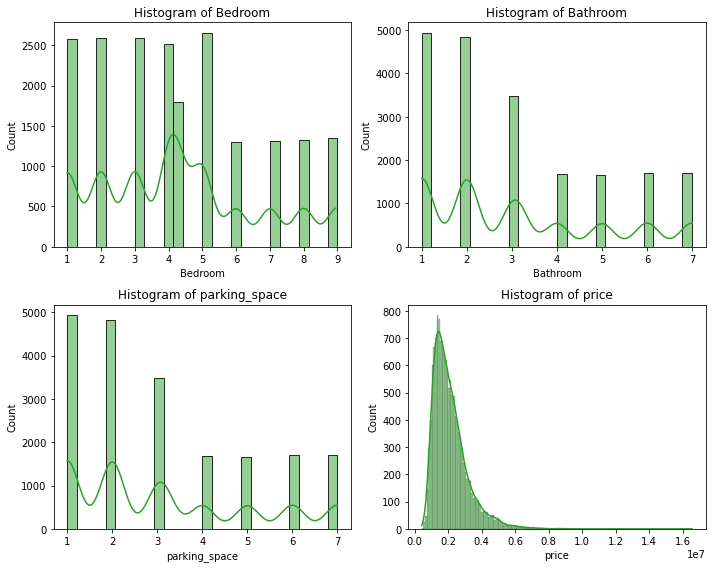

In [21]:
data = combined_df[['bedroom', 'bathroom', 'parking_space', 'price']]

color = sns.color_palette()[2]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram for 'bedroom'
sns.histplot(data['bedroom'], color=color, kde=True, ax=axes[0,0])
axes[0, 0].set_xlabel('Bedroom')
axes[0, 0].set_title('Histogram of Bedroom')

# Histogram for bathroom
sns.histplot(data['bathroom'], color=color, kde=True, ax=axes[0,1])
axes[0,1].set_xlabel('Bathroom')
axes[0,1].set_title('Histogram of Bathroom')

# Histogram for parking_space
sns.histplot(data['bathroom'], color=color, kde=True, ax=axes[1,0])
axes[1,0].set_xlabel('parking_space')
axes[1,0].set_title('Histogram of parking_space')

# Histogram for bathroom
sns.histplot(data['price'], color=color, kde=True, ax=axes[1,1])
axes[1,1].set_xlabel('price')
axes[1,1].set_title('Histogram of price')

plt.tight_layout()
plt.show()

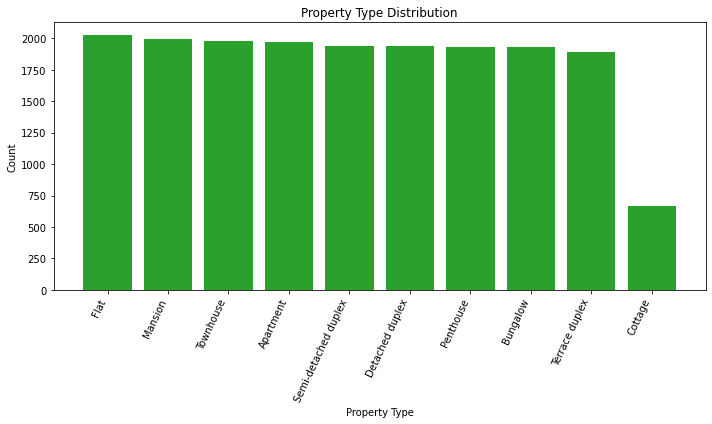

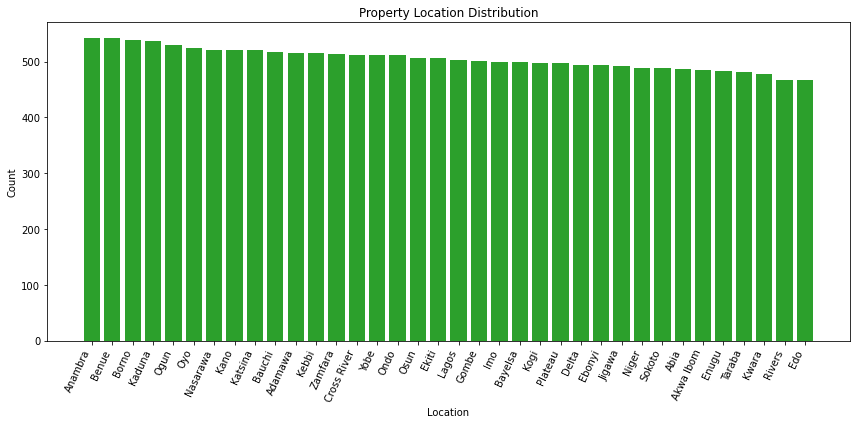

In [39]:
# Create a bar chart to visualize the distribution of different property types

property_type_counts = combined_df['title'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(property_type_counts.index, property_type_counts.values, color=color)
plt.xticks(rotation=65, ha='right')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.title('Property Type Distribution')
plt.tight_layout()
plt.show()

# frequency of property count by state
loc_counts = combined_df['loc'].value_counts()
plt.figure(figsize=(12,6))
plt.bar(loc_counts.index, loc_counts.values, color=color)
plt.xticks(rotation=65, ha='right')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Property Location Distribution')
plt.tight_layout()
plt.show()

In [40]:
# We can also check the correlation between the various features

In [41]:
# Let's include one more feature in the list we have
select_features = combined_df[['bedroom', 'bathroom', 'parking_space', 'price', 'loc']]

# compute the correlation
corr_matrix = select_features.corr()
corr_matrix

,bedroom,bathroom,parking_space,price
bedroom,1.00000,0.21234,0.08896,0.49691
bathroom,0.21234,1.00000,0.13448,0.20480
parking_space,0.08896,0.13448,1.00000,0.08713
price,0.49691,0.20480,0.08713,1.00000


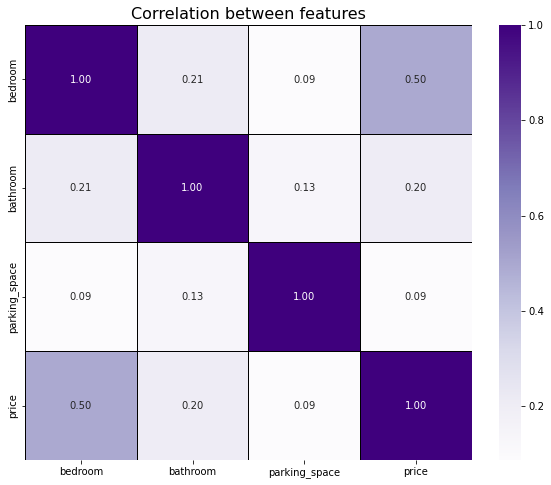

In [44]:
# we can visualize it
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt='.2f', linewidths=0.5, linecolor='black')

plt.title('Correlation between features', fontsize=16)
plt.show()

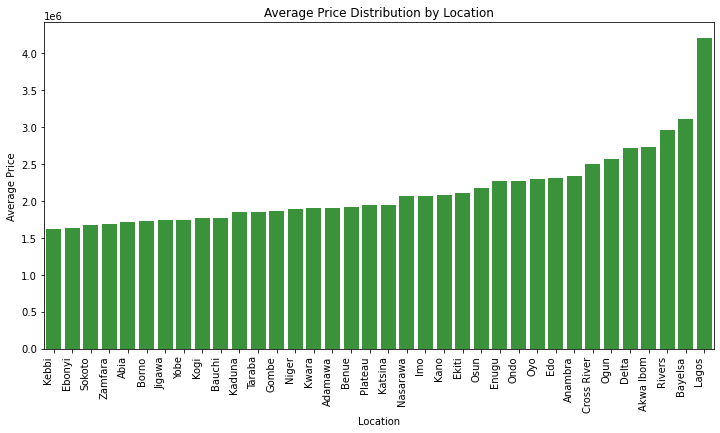

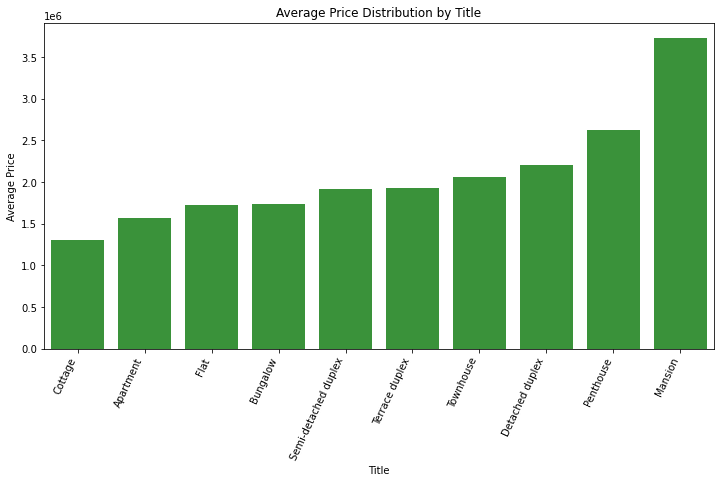

In [64]:
# Grouping the data by location and calculating the mean price for each location
price_by_location = combined_df.groupby('loc')['price'].mean()
price_by_title = combined_df.groupby('title')['price'].mean()

# Sort it in ascending order
price_by_location = price_by_location.sort_values(ascending=True)
price_by_title = price_by_title.sort_values(ascending=True)

# Plotting the bar chart for price distribution by location
plt.figure(figsize=(12, 6))
# price_by_location.plot(kind='bar')
sns.barplot(x=price_by_location.index, y=price_by_location.values, color=color)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.title('Average Price Distribution by Location')
plt.show()

# Plotting the bar chart for price distribution by location
plt.figure(figsize=(12, 6))
# price_by_title.plot(kind='bar')
sns.barplot(x=price_by_title.index, y=price_by_title.values, color=color)
plt.xticks(rotation=65, ha='right')
plt.xlabel('Title')
plt.ylabel('Average Price')
plt.title('Average Price Distribution by Title')
plt.show()

In [61]:
# # Relationship between 'loc' and 'price'
# plt.figure(figsize=(12, 6))
# sns.barplot(x='loc', y='price', data=combined_df, color ='#5e17eb')
# plt.xlabel('Location')
# plt.ylabel('Average Price')
# plt.title('Average Price vs. Location')
# plt.xticks(rotation=90)
# plt.show()

# # Relationship between 'title' and 'price'
# plt.figure(figsize=(10, 6))
# sns.barplot(x='title', y='price', data=combined_df, color ='#5e17eb')
# plt.xlabel('Title')
# plt.ylabel('Average Price')
# plt.title('Average Price vs. Title')
# plt.xticks(rotation=45)
# plt.show()


## Data Preprocessing

In [76]:
combined_df.isnull().sum()

ID                  0
loc                 0
title               0
bedroom             0
bathroom            0
parking_space       0
price            6000
idx                 0
dtype: int64

In [67]:
combined_df.dropna(subset=['loc','title'], inplace=True)
combined_df

,ID,loc,title,bedroom,bathroom,parking_space,price,idx
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500,1
1,2748,Ondo,Apartment,4.30817,2.00000,4.00000,1672416.68900,1
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600,1
4,10300,Kogi,Terrace duplex,4.30817,5.00000,6.00000,2600700.89800,1
5,1733,Borno,Mansion,4.30817,1.00000,3.00000,1341750.86700,1
...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.00000,5.00000,2.00000,NaN,0
5996,2416,Adamawa,Terrace duplex,5.00000,7.00000,1.00000,NaN,0
5997,10195,Oyo,Townhouse,4.00000,1.00000,4.00000,NaN,0
5998,9455,Bauchi,Flat,3.00000,7.00000,5.00000,NaN,0


In [112]:
# # Create a LabelEncoder instance
# le = LabelEncoder()

# # covert the title column to numeric data for the train and test set
# train_clean['title_encoded'] = le.fit_transform(train_clean['title'])
# test['title_encoded'] = le.fit_transform(test['title'])

# # perform one-hot encoding for the 'loc' column
# loc_encoded_train = pd.get_dummies(train_clean['loc'], prefix='loc')
# loc_encoded_test = pd.get_dummies(test['loc'], prefix='loc')

# # concatenate the one-hot encoded columns with the original DataFrame
# train_clean = pd.concat([train_clean, loc_encoded_train], axis=1)
# test = pd.concat([test, loc_encoded_test], axis=1)

# # Drop the original 'title' and 'loc' columns
# train_clean.drop(['title', 'loc', 'ID'], axis=1, inplace=True)
# test.drop(['title', 'loc', 'ID'], axis=1, inplace=True)

# train_clean.shape, test.shape

In [101]:
combined_df

,ID,loc,title,bedroom,bathroom,parking_space,price,idx,is_lagos,is_mansion
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500,1,0,0
1,2748,Ondo,Apartment,4.30817,2.00000,4.00000,1672416.68900,1,0,0
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600,1,0,0
4,10300,Kogi,Terrace duplex,4.30817,5.00000,6.00000,2600700.89800,1,0,0
5,1733,Borno,Mansion,4.30817,1.00000,3.00000,1341750.86700,1,0,1
...,...,...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.00000,5.00000,2.00000,NaN,0,0,0
5996,2416,Adamawa,Terrace duplex,5.00000,7.00000,1.00000,NaN,0,0,0
5997,10195,Oyo,Townhouse,4.00000,1.00000,4.00000,NaN,0,0,0
5998,9455,Bauchi,Flat,3.00000,7.00000,5.00000,NaN,0,0,0


### Feature Engineering

In [78]:
combined_df['is_lagos'] = combined_df['loc'].apply(lambda x: 1 if x == 'Lagos' else 0)
combined_df['is_mansion'] = combined_df['title'].apply(lambda x: 1 if x == 'Mansion' else 0)

In [79]:
combined_df

,ID,loc,title,bedroom,bathroom,parking_space,price,idx,is_lagos,is_mansion
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500,1,0,0
1,2748,Ondo,Apartment,4.30817,2.00000,4.00000,1672416.68900,1,0,0
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600,1,0,0
4,10300,Kogi,Terrace duplex,4.30817,5.00000,6.00000,2600700.89800,1,0,0
5,1733,Borno,Mansion,4.30817,1.00000,3.00000,1341750.86700,1,0,1
...,...,...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.00000,5.00000,2.00000,NaN,0,0,0
5996,2416,Adamawa,Terrace duplex,5.00000,7.00000,1.00000,NaN,0,0,0
5997,10195,Oyo,Townhouse,4.00000,1.00000,4.00000,NaN,0,0,0
5998,9455,Bauchi,Flat,3.00000,7.00000,5.00000,NaN,0,0,0


In [107]:
import category_encoders as ce

encoded_df = combined_df.copy()
 
encoder = ce.TargetEncoder(cols=['loc'])

encoder.fit(encoded_df['loc'], encoded_df['price'])

encoded_df['loc_encoded'] = encoder.transform(encoded_df['loc'])

encoded_df['loc_encoded'] = round((encoded_df['loc_encoded']/10000000),2)

encoded_df.drop('loc', axis=1, inplace=True)

encoded_df

,ID,title,bedroom,bathroom,parking_space,price,idx,is_lagos,is_mansion,loc_encoded
0,3583,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500,1,0,0,0.20000
1,2748,Apartment,4.30817,2.00000,4.00000,1672416.68900,1,0,0,0.23000
3,2224,Detached duplex,5.00000,2.00000,4.00000,2410306.75600,1,0,0,0.24000
4,10300,Terrace duplex,4.30817,5.00000,6.00000,2600700.89800,1,0,0,0.18000
5,1733,Mansion,4.30817,1.00000,3.00000,1341750.86700,1,0,1,0.17000
...,...,...,...,...,...,...,...,...,...,...
5995,1594,Flat,4.00000,5.00000,2.00000,NaN,0,0,0,0.21000
5996,2416,Terrace duplex,5.00000,7.00000,1.00000,NaN,0,0,0,0.19000
5997,10195,Townhouse,4.00000,1.00000,4.00000,NaN,0,0,0,0.23000
5998,9455,Flat,3.00000,7.00000,5.00000,NaN,0,0,0,0.17000


In [108]:
# Calculate the average price for each title
title_average_price = combined_df.groupby('title')['price'].mean()

# Create a new DataFrame to store the title and its corresponding average price
title_avg_price_df = pd.DataFrame({'title': title_average_price.index, 'avg_price': title_average_price.values})

# Sort the DataFrame by the average price in ascending order
title_avg_price_df.sort_values(by='avg_price', inplace=True)

# Create a new column 'title_rank' with the rank based on average price
title_avg_price_df['title_rank'] = range(1, len(title_avg_price_df) + 1)

# Merge the 'title_rank' column back to the original DataFrame based on 'title' column
encoded_df = pd.merge(encoded_df, title_avg_price_df[['title', 'title_rank']], on='title', how='left')

# Sort the DataFrame by 'title_rank' column to order the titles based on average price rank
# encoded_df.sort_values(by='title_rank', inplace=True)

# Drop the 'title_rank' column if you no longer need it
encoded_df.drop('title', axis=1, inplace=True)

# Print the updated DataFrame with the 'title' column ranked by average price
encoded_df

,ID,bedroom,bathroom,parking_space,price,idx,is_lagos,is_mansion,loc_encoded,title_rank
0,3583,2.00000,2.00000,1.00000,1149999.56500,1,0,0,0.20000,5
1,2748,4.30817,2.00000,4.00000,1672416.68900,1,0,0,0.23000,2
2,2224,5.00000,2.00000,4.00000,2410306.75600,1,0,0,0.24000,8
3,10300,4.30817,5.00000,6.00000,2600700.89800,1,0,0,0.18000,6
4,1733,4.30817,1.00000,3.00000,1341750.86700,1,0,1,0.17000,10
...,...,...,...,...,...,...,...,...,...,...
16526,1594,4.00000,5.00000,2.00000,NaN,0,0,0,0.21000,3
16527,2416,5.00000,7.00000,1.00000,NaN,0,0,0,0.19000,6
16528,10195,4.00000,1.00000,4.00000,NaN,0,0,0,0.23000,7
16529,9455,3.00000,7.00000,5.00000,NaN,0,0,0,0.17000,3


In [110]:
combined_df = encoded_df

## Modelling

In [111]:
# We need to splitout the train and test dataset

train = combined_df[combined_df.idx == 1]
test = combined_df[combined_df.idx == 0]

train.drop('idx', axis=1, inplace=True)
test.drop(['idx','price'], axis=1, inplace=True)
train

,ID,bedroom,bathroom,parking_space,price,is_lagos,is_mansion,loc_encoded,title_rank
0,3583,2.00000,2.00000,1.00000,1149999.56500,0,0,0.20000,5
1,2748,4.30817,2.00000,4.00000,1672416.68900,0,0,0.23000,2
2,2224,5.00000,2.00000,4.00000,2410306.75600,0,0,0.24000,8
3,10300,4.30817,5.00000,6.00000,2600700.89800,0,0,0.18000,6
4,1733,4.30817,1.00000,3.00000,1341750.86700,0,1,0.17000,10
...,...,...,...,...,...,...,...,...,...
10526,10477,8.00000,1.00000,6.00000,2837199.08600,0,0,0.19000,8
10527,6175,4.30817,7.00000,0.00000,2367927.86100,0,0,0.23000,4
10528,9704,4.30817,7.00000,5.00000,2228516.47100,0,0,0.19000,2
10529,11190,8.00000,6.00000,5.00000,2406812.69300,0,0,0.19000,4


In [113]:
X = train.drop(['ID', 'price'], axis=1)
y = train.price
X

,bedroom,bathroom,parking_space,is_lagos,is_mansion,loc_encoded,title_rank
0,2.00000,2.00000,1.00000,0,0,0.20000,5
1,4.30817,2.00000,4.00000,0,0,0.23000,2
2,5.00000,2.00000,4.00000,0,0,0.24000,8
3,4.30817,5.00000,6.00000,0,0,0.18000,6
4,4.30817,1.00000,3.00000,0,1,0.17000,10
...,...,...,...,...,...,...,...
10526,8.00000,1.00000,6.00000,0,0,0.19000,8
10527,4.30817,7.00000,0.00000,0,0,0.23000,4
10528,4.30817,7.00000,5.00000,0,0,0.19000,2
10529,8.00000,6.00000,5.00000,0,0,0.19000,4


In [120]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

# Instantiate the dt regressor
dt_reg = DecisionTreeRegressor(random_state=40, max_depth=3, min_samples_split=2, min_samples_leaf=2)

# Perform cross validation on the regressor
cv_scores = cross_val_score(dt_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the decision tree on the training data
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, random_state=40)

In [130]:
# feature_names = X.columns
# tree_graph = tree.export_graphviz(dt_reg, out_file=None, feature_names=feature_names,)
# graphviz.Source(tree_graph)

In [131]:
# Convert the negative MSE scores to positive and take the square root to get RMSE
cv_rmse_scores = (-cv_scores) ** 0.5

# Print the cross-validation scores
print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean CV RMSE:", cv_rmse_scores.mean())

# Evaluate the model on the test set
y_pred = dt_reg.predict(X_test)
test_rmse = ((y_pred - y_test) ** 2).mean() ** 0.5
print("Test set RMSE:", test_rmse)

Cross-validation RMSE scores: [701075.34697587 648473.10288756 666450.81451562 713112.55502657
 691952.25422899]
Mean CV RMSE: 684212.8147269229
Test set RMSE: 695618.090567225


In [134]:
# Assuming you have the features in X and the target variable in y

# Define the CatBoost model
cat_model = CatBoostRegressor(loss_function='RMSE', random_seed=42,silent=True)

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate RMSE
rmse_scores = np.sqrt(-cross_val_score(cat_model, X, y, cv=cv, scoring='neg_mean_squared_error'))

# Train the model on the entire dataset
cat_model.fit(X, y)

# Print the cross-validation RMSE scores
print('Cross-Validation RMSE:', rmse_scores)
print(rmse_scores.mean())

Cross-Validation RMSE: [430339.83086847 519844.95352009 417891.58282345 434021.26915691
 394764.66343611]
439372.4599610066


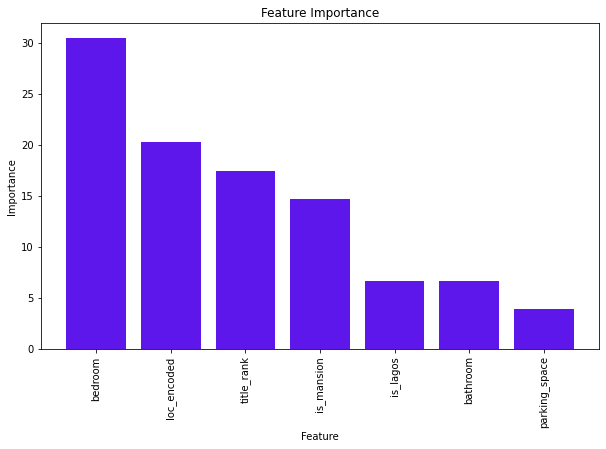

In [135]:
import matplotlib.pyplot as plt
feature_importance = cat_model.get_feature_importance()

# Get the names of the features
feature_names = X.columns

# Create a DataFrame to store the feature importance scores with corresponding feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'],color='#5e17eb')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [145]:
X_test = test.drop(['ID'], axis=1)

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

# Reshape the predicted values to be a 1-dimensional array
y_pred = y_pred.reshape(-1)

# Create a DataFrame with ID and predicted price columns
predictions_df = pd.DataFrame({'ID': test['ID'], 'price': y_pred})

# Display the predictions DataFrame
predictions_df

,ID,price
10531,845,2363811.42714
10532,1924,1019251.36235
10533,10718,1231104.93368
10534,12076,8533099.45167
10535,12254,1904817.98002
...,...,...
16526,1594,1683401.21282
16527,2416,1982469.06084
16528,10195,2004802.50114
16529,9455,1298163.88345


<a name="Predictions"></a>
## Making predictions of the test set and creating a submission file

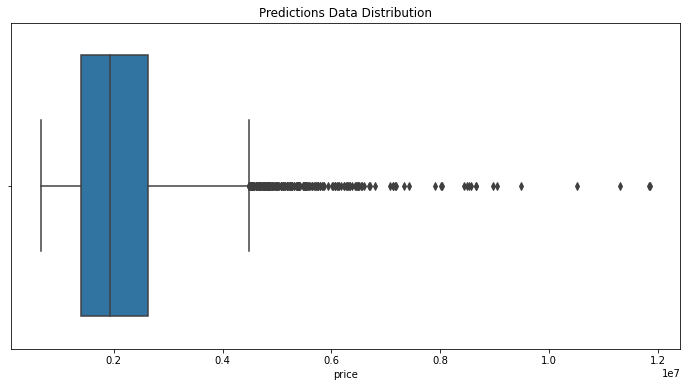

In [143]:
# # Create a submission file
sub_file = submission.copy()
sub_file['price'] = predictions_df.price.values

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.price)
plt.title('Predictions Data Distribution');

 - There are some outliers in our predictions. 
 - More inspection/data preprocessing is needed

In [144]:
sub_file.head()

,ID,price
0,845,2363811.42714
1,1924,1019251.36235
2,10718,1231104.93368
3,12076,8533099.45167
4,12254,1904817.98002


In [146]:
# Write to csv file to submit to Zindi
sub_file.to_csv("submission.csv", index = False)